In [1]:
# downgrade to version 1.2.2
pip install keras==1.2.2

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for keras: filename=Keras-1.2.2-cp36-none-any.whl size=209603 sha256=8aee661e61db5d9c149fbbc9dd9c5a490cb7d4631a910e13af3a1dd3c77f334c
  Stored in directory: /root/.cache/pip/wheels/55/07/cf/b32db0a8d243b2fd6759d5d7cb650aa20670b2b740209cbf7e
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 1.2.2 which is incompatible.
ERROR: kapre 0.1.3.1 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
# imports
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Merge, Dropout, Input, merge
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/Colab Notebooks/520 Final project"

520final.ipynb			   unique_1126.p     weights_1.h
encoded_images_inceptionV3.p	   unique1.p	     weights_222.h
encoded_images_test_inceptionV3.p  unique.p	     weights_22.h
encoded_images_val_inceptionV3.p   unique_words.p    weights_2.h
Flickr8k			   weights_111.h     weights_33.h
idx2word_1126.p			   weights_1126_1.h  weights_3.h
images_filename.p		   weights_1126_2.h  word2idx_1126.p
time_inceptionV3_1.5987_loss.h5    weights_11.h


In [0]:
# get captions
token = "/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
captions = open(token, 'r').read().strip().split('\n')

In [0]:
# create dic
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [7]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
images = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flicker8k_Dataset/'

In [0]:
# get image data
images = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/520 Final project/images_filename.p", "wb") as img_pickle:
    pickle.dump(img, img_pickle)

In [0]:
img = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/images_filename.p", 'rb'))

In [0]:
train_images_file = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_file = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
val_images_file = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
train_img = list(open(train_images_file, 'r').read().strip().split('\n'))
test_img = list(open(test_images_file, 'r').read().strip().split('\n'))
val_img = list(open(val_images_file, 'r').read().strip().split('\n'))

In [11]:
print("train_img: {}, test_img: {}, val_img: {}".format(len(train_img), len(test_img), len(val_img)))

train_img: 6000, test_img: 1000, val_img: 1000


Text(0.5, 1.0, 'A black dog is running after a white dog in the snow .')

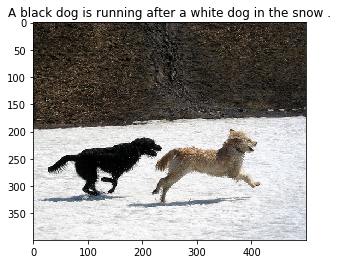

In [13]:
plt.imshow(Image.open(images + train_img[0]))
plt.title(d[train_img[0]][0])

In [0]:
# resize and scale to -1 to 1
def preprocess(image_name):
    img = np.array(Image.open(images + image_name))
    img = cv2.resize(img, (299, 299), interpolation = cv2.INTER_AREA)
    processed_img = np.expand_dims(img, axis=0)
    processed_img = (processed_img / 255 - 0.5) * 2
    return processed_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'A black dog is running after a white dog in the snow .')

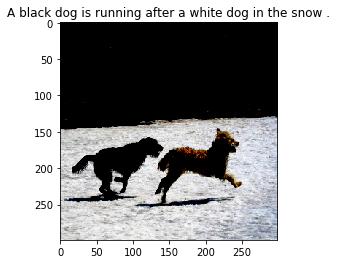

In [15]:
plt.imshow(np.squeeze(preprocess(train_img[0])))
plt.title(d[train_img[0]][0])

In [16]:
# InceptionV3 encoder
from keras.models import Model
# Use the hidden layer as output
model = InceptionV3(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output
model_new = Model(new_input, hidden_layer)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Instructions for updating:
keep_dims is deprecated, use keepdims instead







In [0]:
def encode_img(img):
  img = preprocess(img)
  encoded_img = model_new.predict(img)
  encoded_img = np.reshape(encoded_img, encoded_img.shape[1])
  return encoded_img

In [0]:
# generate encoded image data
# encoded_train = {}
# for img in tqdm(train_img):
#     encoded_train[img] = encode_img(img)

In [18]:
# encoded_test = {}
# for img in tqdm(test_img):
#     encoded_test[img] = encode_img(img)

100%|██████████| 1000/1000 [06:54<00:00,  2.47it/s]


In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoded_test, encoded_pickle)

In [0]:
# encoded_val = {}
# for img in tqdm(val_img):
#     encoded_val[img[len]] = encode_img(img)

100%|██████████| 1000/1000 [10:27<00:00,  1.77it/s]


In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_val_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoded_val, encoded_pickle)

In [0]:
# Run this to get the training data
encoded_train = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_inceptionV3.p", 'rb'))

In [0]:
len(encoded_test)

1000

In [0]:
# Run this to get the test data
encoded_test = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_test_inceptionV3.p", 'rb'))

We may append the output of YOLO afterwards

In [0]:
# Get the train dic
train_d = {}
for i in train_img:
    if i in d:
        train_d[i] = d[i]

In [22]:
train_d['3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
# words = [i.split() for i in caps]

In [0]:
# unique = []
# for i in words:
#     unique.extend(i)

In [0]:
# unique = list(set(unique))

In [0]:
# #Unique words for vocabulart

# words = [i.split() for i in caps]

# unique = []
# for i in words:
#     unique.extend(i)
# unique = list(set(unique))

In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/unique_1126.p", "wb") as unique_words:
#     pickle.dump(unique, unique_words)

In [0]:
# get the unique words
unique = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/unique.p", 'rb'))

In [0]:
# word2idx = {val:index for index, val in enumerate(unique)}
# idx2word = {index:val for index, val in enumerate(unique)}

In [0]:
word2idx = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/word2idx_1126.p", 'rb'))

In [0]:
idx2word = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/idx2word_1126.p", 'rb'))

In [31]:
word2idx['<start>']

5085

In [32]:
idx2word[2933]

'illustration'

In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/word2idx_1126.p", "wb") as word2idx_pickle:
#     pickle.dump(word2idx, word2idx_pickle)

In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/idx2word_1126.p", "wb") as idx2word_pickle:
#     pickle.dump(idx2word, idx2word_pickle)

In [0]:
vocab_size = len(unique)

In [34]:
vocab_size

8256

In [35]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key + "\t" + "<start> " + i +" <end>" + "\n")
f.close()

In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [38]:
samples_per_epoch

383454

In [39]:
# max length of captions
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
# data generator
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoded_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)               
                    n = np.zeros(vocab_size)
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [0]:
embedding_size = 300

In [0]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [43]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [44]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [45]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [46]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=10, 
                          verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


686s - loss: 4.0485 - acc: 0.3102
Epoch 2/10


KeyboardInterrupt: ignored

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=10, 
                          verbose=2)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


669s - loss: 3.1942 - acc: 0.4549
Epoch 2/10
681s - loss: 3.1636 - acc: 0.4591
Epoch 3/10
672s - loss: 3.1404 - acc: 0.4630
Epoch 4/10
675s - loss: 3.1327 - acc: 0.4686
Epoch 5/10
685s - loss: 3.1165 - acc: 0.4736
Epoch 6/10
692s - loss: 3.0984 - acc: 0.4762
Epoch 7/10
657s - loss: 3.0927 - acc: 0.4782
Epoch 8/10
640s - loss: 3.0775 - acc: 0.4816
Epoch 9/10
640s - loss: 3.0680 - acc: 0.4832
Epoch 10/10
641s - loss: 3.0577 - acc: 0.4870


In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=10, 
                          verbose=2)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


943s - loss: 3.2513 - acc: 0.4525
Epoch 2/10
945s - loss: 3.2502 - acc: 0.4550
Epoch 3/10
932s - loss: 3.2133 - acc: 0.4603
Epoch 4/10
916s - loss: 3.1937 - acc: 0.4647
Epoch 5/10
936s - loss: 3.1447 - acc: 0.4682
Epoch 6/10
938s - loss: 3.1436 - acc: 0.4716
Epoch 7/10
943s - loss: 3.1170 - acc: 0.4748
Epoch 8/10
944s - loss: 3.1065 - acc: 0.4776
Epoch 9/10
944s - loss: 3.0823 - acc: 0.4803
Epoch 10/10
945s - loss: 3.0596 - acc: 0.4836


In [0]:
final_model.load_weights('/content/drive/My Drive/Colab Notebooks/520 Final project/weights_1126_2.h')

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoded_test[image]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Two dogs are running in the grass .


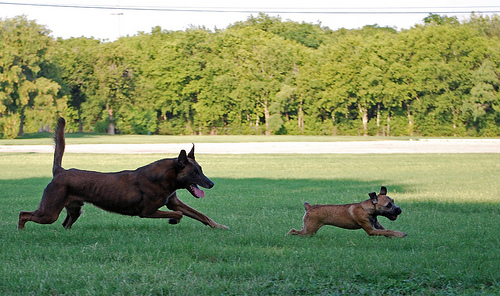

In [62]:
a = test_img[18]

print(predict_captions(a))
Image.open(images + a)